# Hiragana convolutional network

The Hiragana datatset is composed of the 46 japanese characters called hiragana. Each folder is named after the hiragana name and contains 100 jpg images of handwritten hiragana.

In [19]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import defaultdict

In [20]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import numpy as np
from tqdm import tqdm

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## Set seed

In [22]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

## Dataset

In [23]:
DATA_DIR = "hiragana-dataset"
BATCH_SIZE = 32
IMAGE_SIZE = 64
NUM_CLASSES = 46
EPOCHS = 15
LR = 1e-3

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Data augmentation

Data augmentation consist in small processing steps like small rotation, scaling etc. Be careful to not do any horizontal flip as it might change the meaning of the hiragana. the hiragana images are already inn black and white.

In [25]:
train_transform =  transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [26]:
val_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])

## Load the hiragana dataset with Imagefolder

In [27]:
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)
print("Classes:", full_dataset.classes)
print("Number of images:", len(full_dataset))

Classes: ['aa', 'chi', 'ee', 'fu', 'ha', 'he', 'hi', 'ho', 'ii', 'ka', 'ke', 'ki', 'ko', 'ku', 'ma', 'me', 'mi', 'mo', 'mu', 'na', 'ne', 'ni', 'nn', 'no', 'nu', 'oo', 'ra', 're', 'ri', 'ro', 'ru', 'sa', 'se', 'shi', 'so', 'su', 'ta', 'te', 'to', 'tsu', 'uu', 'wa', 'wo', 'ya', 'yo', 'yu']
Number of images: 4600


## Stratified Train/Validation split 

I want to make sure I have all the classes represented in each set.

In [28]:
def stratified_split(dataset, val_ratio = 0.2, seed=42):
    np.random.seed(seed)
    class_indices = defaultdict(list)
    
    for idx, (_,label) in enumerate(dataset.samples):
        class_indices[label].append(idx)
        
    train_idx, val_idx = [], []
    for label, indices in class_indices.items():
        np.random.shuffle(indices)
        split = int(len(indices) * (1 - val_ratio))
        train_idx.extend(indices[:split])
        val_idx.extend(indices[split:])
        
    return train_idx, val_idx

train_idx, val_idx = stratified_split(full_dataset, val_ratio=0.2)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(datasets.ImageFolder(DATA_DIR, transform=val_transform),
                     val_idx)

In [29]:
print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))

Train size: 3680
Validation size: 920


## DataLoaders

In [30]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [31]:
images, labels = next(iter(train_loader))
print(images.shape) # e.g., torch.Size([32, 1, 64, 64])
print(labels[:5])

torch.Size([32, 1, 64, 64])
tensor([35,  9, 42, 27, 19])


## Hiragana CNN model

### Model definition

In [32]:
class HiraganaCNN(nn.Module):
    def __init__(self, num_classes=46):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Initialize the model

In [33]:
model = HiraganaCNN(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR) # LR = 1e-3
print(model)

HiraganaCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(

## Training

In [34]:
for epoch in range(EPOCHS):
    model.train()
    train_loss=0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    # Validation part
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    
    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}]" f"Loss: {train_loss:.3f} | Val Acc: {acc:.2f}%")
    

100%|██████████| 115/115 [00:32<00:00,  3.53it/s]


Epoch [1/15]Loss: 452.175 | Val Acc: 18.37%


100%|██████████| 115/115 [00:29<00:00,  3.84it/s]


Epoch [2/15]Loss: 328.800 | Val Acc: 76.52%


100%|██████████| 115/115 [00:28<00:00,  4.07it/s]


Epoch [3/15]Loss: 246.308 | Val Acc: 91.85%


100%|██████████| 115/115 [00:31<00:00,  3.67it/s]


Epoch [4/15]Loss: 211.531 | Val Acc: 97.93%


100%|██████████| 115/115 [00:29<00:00,  3.91it/s]


Epoch [5/15]Loss: 188.690 | Val Acc: 99.57%


100%|██████████| 115/115 [00:28<00:00,  4.01it/s]


Epoch [6/15]Loss: 179.153 | Val Acc: 97.61%


100%|██████████| 115/115 [00:29<00:00,  3.96it/s]


Epoch [7/15]Loss: 171.453 | Val Acc: 93.80%


100%|██████████| 115/115 [00:28<00:00,  3.97it/s]


Epoch [8/15]Loss: 165.542 | Val Acc: 99.02%


100%|██████████| 115/115 [00:28<00:00,  4.02it/s]


Epoch [9/15]Loss: 159.225 | Val Acc: 99.57%


100%|██████████| 115/115 [00:28<00:00,  4.00it/s]


Epoch [10/15]Loss: 155.724 | Val Acc: 99.89%


100%|██████████| 115/115 [00:29<00:00,  3.87it/s]


Epoch [11/15]Loss: 148.018 | Val Acc: 99.67%


100%|██████████| 115/115 [00:29<00:00,  3.83it/s]


Epoch [12/15]Loss: 154.770 | Val Acc: 99.78%


100%|██████████| 115/115 [00:29<00:00,  3.92it/s]


Epoch [13/15]Loss: 146.109 | Val Acc: 99.35%


100%|██████████| 115/115 [00:34<00:00,  3.38it/s]


Epoch [14/15]Loss: 147.287 | Val Acc: 99.78%


100%|██████████| 115/115 [00:32<00:00,  3.59it/s]


Epoch [15/15]Loss: 140.494 | Val Acc: 100.00%


## Prediction

### Class mapping

In [35]:
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}
print(idx_to_class)

{0: 'aa', 1: 'chi', 2: 'ee', 3: 'fu', 4: 'ha', 5: 'he', 6: 'hi', 7: 'ho', 8: 'ii', 9: 'ka', 10: 'ke', 11: 'ki', 12: 'ko', 13: 'ku', 14: 'ma', 15: 'me', 16: 'mi', 17: 'mo', 18: 'mu', 19: 'na', 20: 'ne', 21: 'ni', 22: 'nn', 23: 'no', 24: 'nu', 25: 'oo', 26: 'ra', 27: 're', 28: 'ri', 29: 'ro', 30: 'ru', 31: 'sa', 32: 'se', 33: 'shi', 34: 'so', 35: 'su', 36: 'ta', 37: 'te', 38: 'to', 39: 'tsu', 40: 'uu', 41: 'wa', 42: 'wo', 43: 'ya', 44: 'yo', 45: 'yu'}


### Predict one image

In [36]:
from PIL import Image

In [37]:
def predict_image(image_path):
    img = Image.open(image_path)
    img = val_transform(img).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(img)
        pred = torch.argmax(output, 1).item()
        
    return idx_to_class[pred]

In [38]:
print(predict_image("hiragana-dataset/aa/drawing_20250805_081540.jpg"))

aa


## Save model

In [39]:
torch.save(model.state_dict(), "hiragana_cnn.pth")

In [40]:
torch.save({
    "model_state": model.state_dict(),
    "class_names": full_dataset.classes
}, "hiragana_cnn_model.pth")


## Confusion matrix

In [41]:
model = HiraganaCNN()
model.load_state_dict(torch.load("hiragana_cnn.pth", map_location="cpu"))
model.eval()

/var/folders/qt/d9mrqr1s6z536_h0j4_x7wpc0000gp/T/ipykernel_47214/1933460624.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("hiragana_cn

HiraganaCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(

In [42]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


In [43]:
cm = confusion_matrix(all_labels, all_preds)
print(cm.shape)

(46, 46)


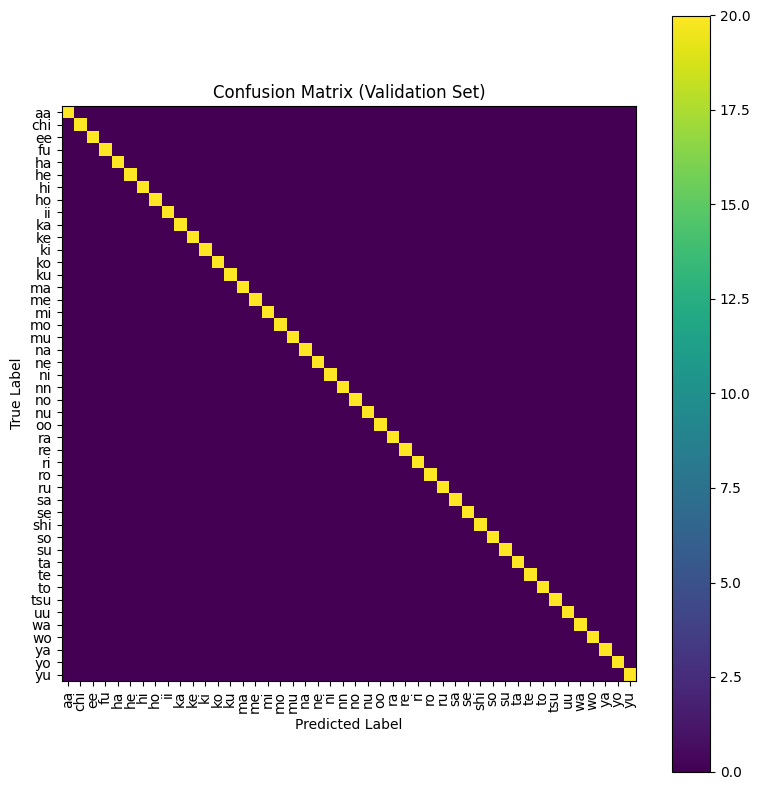

In [44]:
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Validation Set)")
plt.colorbar()

tick_marks = np.arange(NUM_CLASSES)
plt.xticks(tick_marks, full_dataset.classes, rotation=90)
plt.yticks(tick_marks, full_dataset.classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
